In [2]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nrrd
import json

In [3]:
# Define the folder containing the images
current_directory = os.getcwd()
print(os.getcwd())

C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23


In [4]:
directory = current_directory + "\\tif\\"

Training Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 22, 244



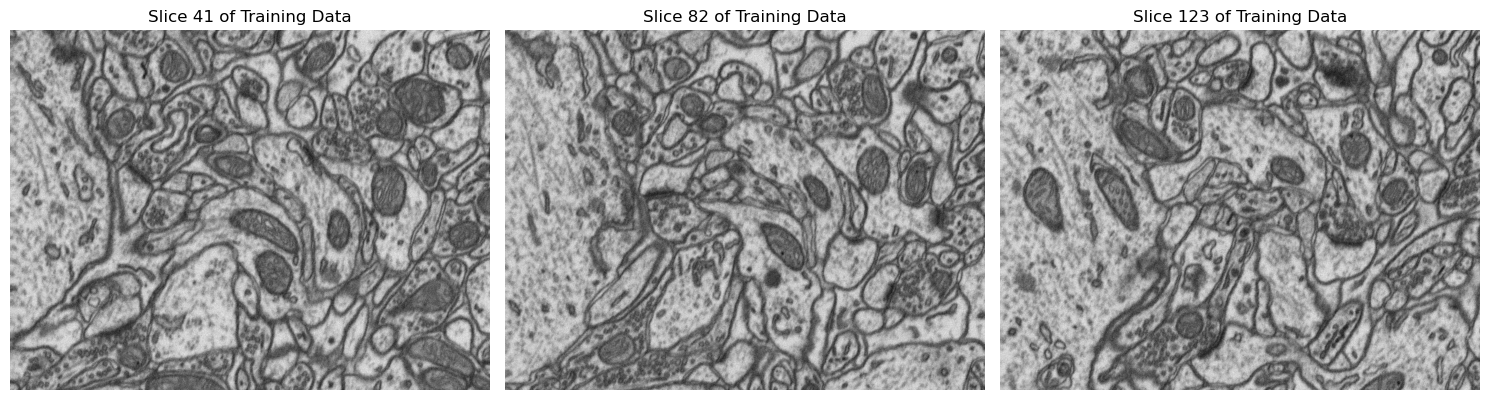

Training Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



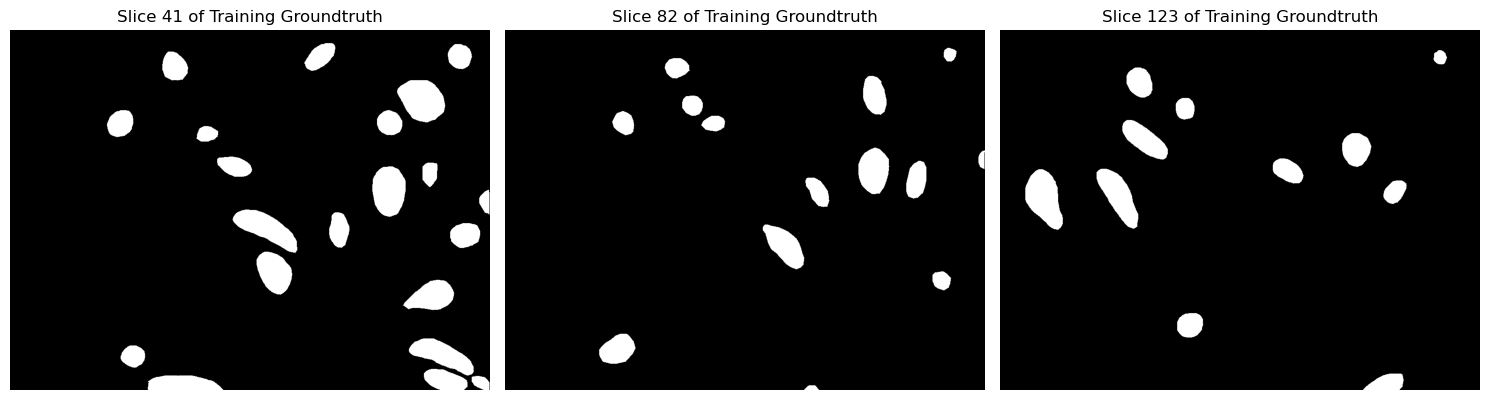

Testing Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 2, 255



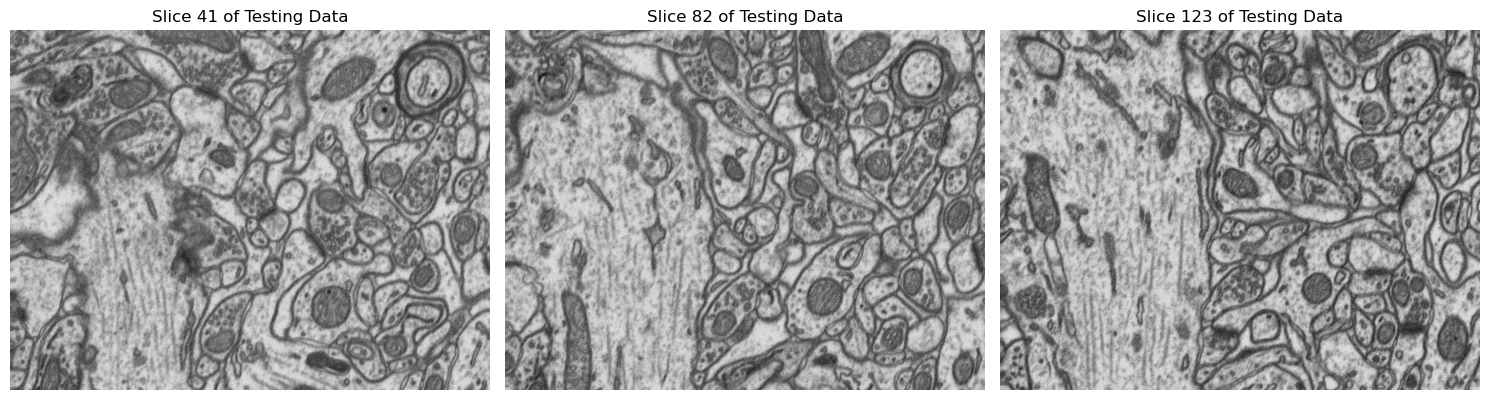

Testing Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



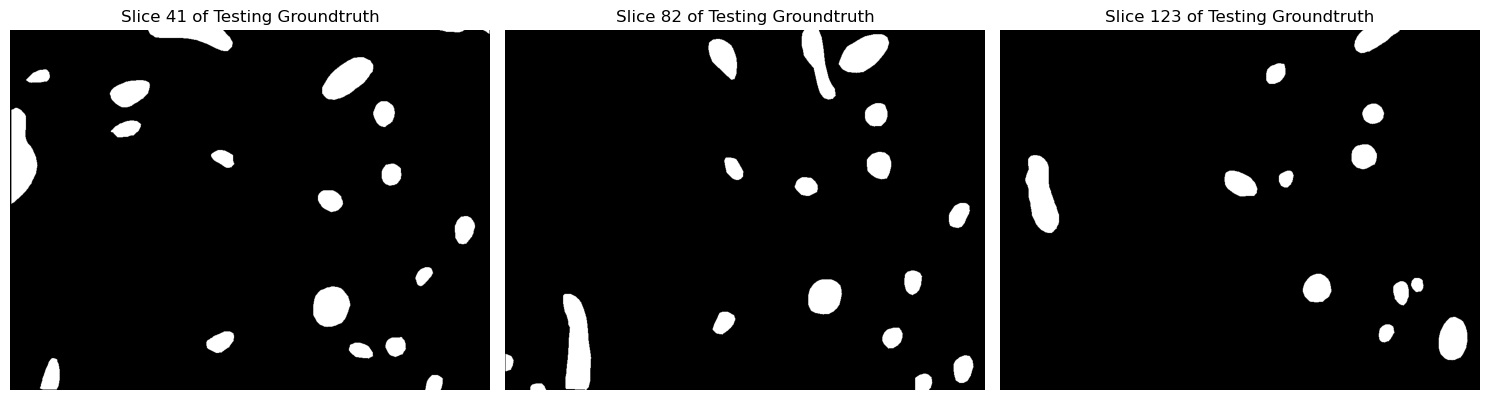

In [5]:
# Define the folder containing the images
current_directory = os.getcwd()
directory = current_directory + "\\tif\\" # replace with the path to your directory

# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

datasets = {
    "Training Data": train_data,
    "Training Groundtruth": train_groundtruth,
    "Testing Data": test_data,
    "Testing Groundtruth": test_groundtruth
}

# Exploring and visualizing the datasets
for name, data in datasets.items():
    print(f"{name}:")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Min and max values: {data.min()}, {data.max()}\n")

    # Visualize some slices
    num_slices = data.shape[0]
    sample_slices = [num_slices//4, num_slices//2, 3*num_slices//4]

    fig, axes = plt.subplots(1, len(sample_slices), figsize=(15, 5))
    for idx, slice_idx in enumerate(sample_slices):
        axes[idx].imshow(data[slice_idx, ...], cmap='gray')
        axes[idx].set_title(f'Slice {slice_idx} of {name}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [234]:
# Load resized images from folders
def load_resized_data(data_dir, filename):
    data = np.zeros((165, 128, 128), dtype=np.uint8)
    for i in range(165):
        data[i] = tiff.imread(os.path.join(data_dir, f'{os.path.basename(filename)}_{i}.tif'))
    return data

print(directory)

resized_train_data = load_resized_data(directory + "reTrain", "train")
resized_train_groundtruth = load_resized_data(directory + "reTrainGT", "train_gt" )
resized_test_data = load_resized_data(directory + "reTest", "test")
resized_test_groundtruth = load_resized_data(directory + "reTestGT", "test_gt")


C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23\tif\


In [235]:

def dynamic_kernel_size(contour, min_size=100, max_size=750):
    # This function determines the kernel size based on contour area
    area = cv2.contourArea(contour)
    if area < min_size:
        return 1  # Smallest kernel for small objects
    elif area > max_size:
        return 3  # Larger kernel for big objects
    else:
        # Interpolate kernel size for areas in between
        return int(round(1 + (area - min_size) / (max_size - min_size) * (3 - 1)))
    
def mask_to_bboxes(mask_path, output_path):
    # Load the mask image
    mask = cv2.imread(mask_path, 0)

    # Find contours to estimate size distribution
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty mask to draw individual dilated objects
    dilated_mask = np.zeros_like(mask)

    # Dilate individual objects based on their size
    for contour in contours:
        kernel_size = dynamic_kernel_size(contour)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        cv2.drawContours(dilated_mask, [contour], -1, 255, -1)
        dilated_mask = cv2.dilate(dilated_mask, kernel, iterations=1)

    # Re-find contours on the dilated mask
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to hold bounding box annotations
    bboxes = []
    
    # Calculate bounding boxes from contours on the dilated mask
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h
        bboxes.append([x_min, y_min, x_max, y_max])
    
    # Save bounding boxes in a JSON file
    with open(output_path, 'w') as f:
        json.dump(bboxes, f)

def process_masks(source_folder, target_folder):
    # Create the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Process all mask images in the source folder
    for mask_filename in os.listdir(source_folder):
        if mask_filename.endswith('.tif') or mask_filename.endswith('.tiff'):
            mask_path = os.path.join(source_folder, mask_filename)
            output_path = os.path.join(target_folder, os.path.splitext(mask_filename)[0] + '.json')
            mask_to_bboxes(mask_path, output_path)

**Dynamic Kernel Size Adaptation for Improved Bounding Box Generation**

In the context of preparing a dataset for object detection models, accurate bounding box annotation is crucial. Our dataset, derived from high-resolution electron microscopy, requires careful preprocessing to ensure the distinctiveness of each biological structure is maintained. We address the challenge of accurate bounding box generation by introducing a dynamic kernel size adaptation method within our mask_to_bboxes function.

The dynamic_kernel_size function dynamically determines the kernel size for the dilation operation based on the contour area of detected objects within the binary mask. This is done to separate close-together objects, which are otherwise prone to be enclosed within a single bounding box. The function employs a heuristic approach where a smaller kernel is used for objects smaller than a predefined min_size, and a larger kernel for objects greater than max_size, with a linear interpolation for sizes in between. This strategy allows us to handle varying object sizes uniquely and effectively, preventing the aggregation of multiple objects into one bounding box, particularly for closely situated objects.

After the dynamic dilation step, we recompute the contours, which now represent more accurately separated objects. For each contour, we calculate the bounding box coordinates and save them in a JSON format. This approach ensures that our bounding boxes are robust, minimizing overlaps and capturing the full extent of each object.

The process_masks function automates the processing of masks by iterating through all the mask images within specified source folders (reTestGT and reTrainGT). It creates corresponding bounding box annotations and stores them in target folders (reTestJs and reTrainJs), ensuring an organized and systematic structure for our dataset annotations.

In [236]:
# Define the paths to the source folders
reTest_dir = directory + 'reTestGT\\'
reTrain_dir = directory + 'reTrainGT\\'

# Define the paths to the target folders
reTestJs_dir = directory + 'reTestJs\\'
reTrainJs_dir = directory + 'reTrainJs\\'

# Convert masks to bounding boxes for both reTest and reTrain
process_masks(reTest_dir, reTestJs_dir)
process_masks(reTrain_dir, reTrainJs_dir)

In [239]:
import matplotlib.pyplot as plt
from random import choice

def draw_bounding_boxes(image, bboxes):
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (w, h), (255, 0, 0), 1)
    return image

def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def visualize_random_mask_with_bboxes(base_dir, mask_dir, json_dir):
    mask_files = os.listdir(os.path.join(base_dir, mask_dir))
    random_mask_file = choice(mask_files)
    mask_path = os.path.join(base_dir, mask_dir, random_mask_file)
    
    json_path = os.path.join(base_dir, json_dir, os.path.splitext(random_mask_file)[0] + '.json')
    bboxes = load_json(json_path)

    # Load image
    image = cv2.imread(mask_path)
    image_with_bboxes = draw_bounding_boxes(image.copy(), bboxes)

    # Convert color from BGR to RGB
    image_with_bboxes = cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_with_bboxes)
    plt.title('Mask with Bounding Boxes')
    plt.axis('off')

    plt.show()

To verify the accuracy of our bounding box generation process, we implement the visualize_random_mask_with_bboxes function. This visualization function randomly selects a mask from a specified directory, draws the calculated bounding boxes on the mask, and displays the original mask alongside the mask with bounding boxes. This step is critical for qualitative assessment, allowing us to visually confirm that our dynamic kernel size approach effectively captures individual objects without unnecessary grouping and includes objects located near the mask edges.

By employing this dynamic approach to bounding box generation, we aim to enhance the quality of our dataset, which is foundational to the success of any object detection model. It is particularly well-suited to our project, which revolves around the precise identification of cellular structures, where the clear delineation of each object is essential for subsequent analysis stages.

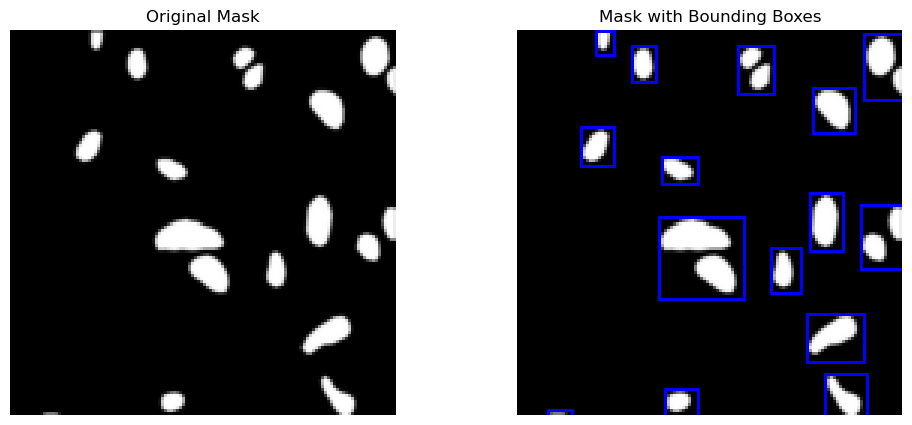

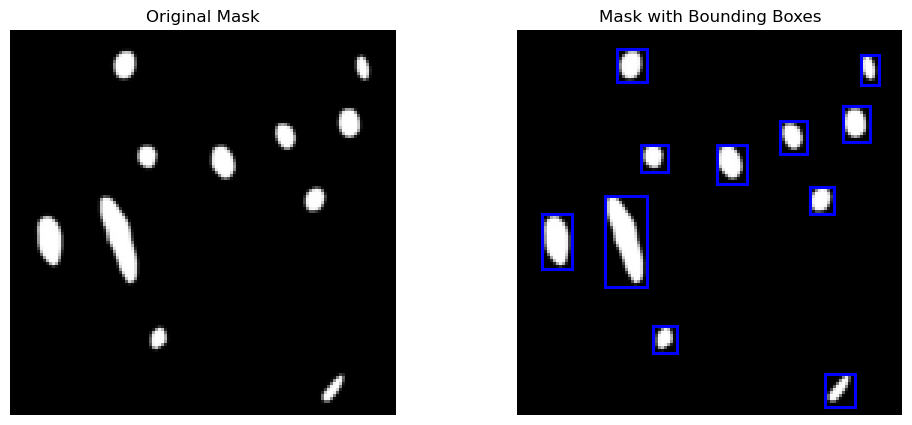

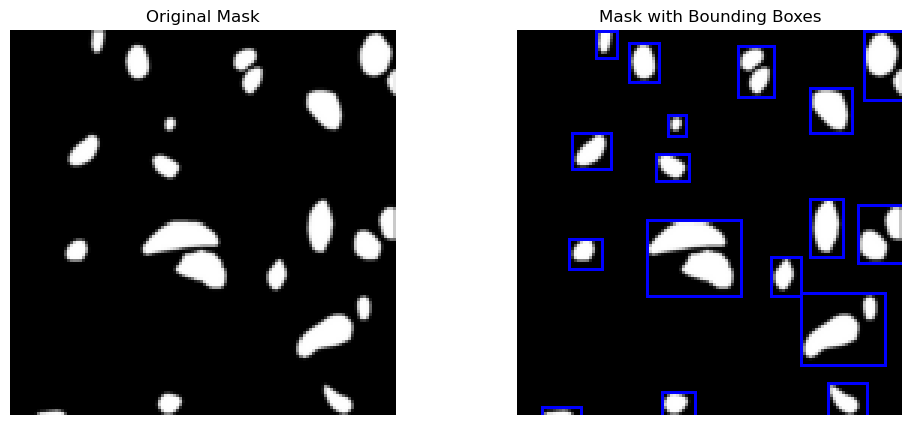

In [240]:
# Base directory where the folders are located
base_dir = 'your_base_directory_here'
visualize_random_mask_with_bboxes(directory, 'reTrainGT', 'reTrainJs')
visualize_random_mask_with_bboxes(directory, 'reTrainGT', 'reTrainJs')
visualize_random_mask_with_bboxes(directory, 'reTrainGT', 'reTrainJs')

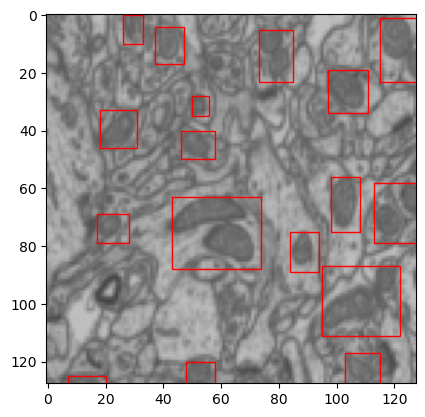

In [244]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Set the directory where your images and JSON annotation files are located
image_dir = directory + 'reTrain\\'
json_dir = directory + 'reTrainJs\\'

# Load an example image and its corresponding annotation
image_path = os.path.join(image_dir, 'train_0.tif')
json_path = os.path.join(json_dir, 'train_gt_0.json')

# Read image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Assuming 'json_path' is the path to your JSON file and 'image' is the image array
with open(json_path, 'r') as f:
    annotation = json.load(f)

# Assuming annotation contains a list of lists in the format [x_min, y_min, x_max, y_max]
bboxes = annotation  # Use the annotation directly if it's already in the correct format

# Visualize the image and the bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')  # Use cmap='gray' if the image is grayscale

# Add rectangles for the bounding boxes
for bbox in bboxes:
    x_min, y_min, x_max, y_max = bbox
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


For object detection, especially when starting with a basic model, a common approach is to use a Single Shot Detector (SSD) or a Faster R-CNN with a pre-trained backbone like VGG16, ResNet, or MobileNet. These models are well-established in the field and offer a good balance between accuracy and computational efficiency.

SSD (Single Shot MultiBox Detector):

SSD is fast and efficient, which makes it a good choice for starting out.
It uses a single neural network to detect multiple objects within the image in one go, hence the name "Single Shot".
SSD with a MobileNet backbone is particularly lightweight and suitable if you have constraints on computational resources.
Faster R-CNN:

Faster R-CNN is more accurate than SSD but requires more computational power.
It uses a Region Proposal Network (RPN) to generate potential bounding boxes in an image and then uses a CNN to classify these regions.
Given that you have the bounding boxes ready in JSON format, you'll need to preprocess the data into a format that is compatible with these models. For both SSD and Faster R-CNN, you'll need to:

Convert JSON to the required format: Both models expect specific input formats. For TensorFlow implementations, you might use the TFRecord format.
Normalize the image sizes: Object detection models typically require input images of a fixed size.
Split the dataset: Make sure you have a training set and a validation set to properly train and evaluate the model's performance.
Here's a basic outline of how you can proceed with SSD and pre-processing steps:

Pre-processing:

Read your images and corresponding JSON files.
Convert the bounding box coordinates from the JSON files into the format expected by the model (e.g., xmin, ymin, xmax, ymax).
Resize images to the input size expected by the model, adjusting bounding boxes accordingly.
Normalize the image pixel values (e.g., divide by 255 to get values between 0 and 1).
Split your data into training and validation sets.
Model Selection:

Use a pre-trained SSD model with an appropriate backbone. TensorFlow's Object Detection API provides pre-trained models that can be fine-tuned on your dataset.
Training:

Fine-tune the model on your dataset, using the pre-processed images and bounding boxes.
Use data augmentation to improve generalization.
Evaluation:

Validate the model using your validation set and adjust hyperparameters as needed.
Use metrics like mAP (mean Average Precision) for evaluation.
Inference:

Run the model on unseen images to detect objects.
Starting with TensorFlow's Object Detection API would be a good choice, as it abstracts away many of the complexities and provides a streamlined process for training object detection models.

**SSD Single Shot Detector**

In [345]:
import re

def get_numerical_suffix(filename):
    match = re.search(r'(\d+)\.', filename)
    return int(match.group(1)) if match else None

def load_data_and_preprocess(image_dir, json_dir, max_boxes_per_image, image_size):
    images = []
    labels = []

    # Get the sorted list of image and json files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    json_files = sorted([f for f in os.listdir(json_dir) if f.endswith('.json')])

    # Verify that the number of image files and json files match
    assert len(image_files) == len(json_files), "The number of image and json files do not match."

    for image_filename, json_filename in zip(image_files, json_files):
        # Load and preprocess the image
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_size, image_size))
        images.append(image)

        # Load the corresponding JSON file
        json_path = os.path.join(json_dir, json_filename)
        with open(json_path, 'r') as f:
            annot = json.load(f)

        # Assuming the JSON structure is a list of lists: [[x, y, width, height], ...]
        # You might need to adjust this line if your JSON structure is different
        boxes = [box for box in annot]
        
        print(f"Loaded bounding boxes for image {image_filename}: {boxes}")

        # Padding boxes
        while len(boxes) < max_boxes_per_image:
            boxes.append([0, 0, 0, 0])  # Pad with dummy boxes

        labels.append(boxes[:max_boxes_per_image])  # Limit to max_boxes_per_image
        print(f"Processed bounding boxes for image {image_filename}: {labels[-1]}")

    images = np.array(images)
    labels = np.array(labels)
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    return images, labels

In [346]:
IMAGE_SIZE = 128  # Replace with your desired image size
MAX_BOXES_PER_IMAGE = 20  # Set this to the maximum number of boxes you expect in any image

# Example usage
train_images, train_labels = load_data_and_preprocess(
    os.path.join(BASE_DIR, 'reTrain'),
    os.path.join(BASE_DIR, 'reTrainJS'),
    MAX_BOXES_PER_IMAGE,
    IMAGE_SIZE
)
test_images, test_labels = load_data_and_preprocess(
    os.path.join(BASE_DIR, 'reTest'),
    os.path.join(BASE_DIR, 'reTestJS'),
    MAX_BOXES_PER_IMAGE,
    IMAGE_SIZE
)

# Now check the shapes again
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Loaded bounding boxes for image train_0.tif: [[7, 125, 20, 128], [48, 120, 58, 128], [103, 117, 115, 128], [95, 87, 122, 111], [84, 75, 94, 89], [17, 69, 28, 79], [43, 63, 74, 88], [113, 58, 128, 79], [98, 56, 108, 75], [46, 40, 58, 50], [18, 33, 31, 46], [50, 28, 56, 35], [97, 19, 111, 34], [73, 5, 85, 23], [37, 4, 47, 17], [115, 1, 128, 23], [26, 0, 33, 10]]
Processed bounding boxes for image train_0.tif: [[7, 125, 20, 128], [48, 120, 58, 128], [103, 117, 115, 128], [95, 87, 122, 111], [84, 75, 94, 89], [17, 69, 28, 79], [43, 63, 74, 88], [113, 58, 128, 79], [98, 56, 108, 75], [46, 40, 58, 50], [18, 33, 31, 46], [50, 28, 56, 35], [97, 19, 111, 34], [73, 5, 85, 23], [37, 4, 47, 17], [115, 1, 128, 23], [26, 0, 33, 10], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image train_1.tif: [[8, 125, 21, 128], [48, 120, 59, 128], [103, 117, 116, 128], [94, 87, 122, 111], [84, 75, 94, 88], [17, 69, 28, 79], [43, 63, 74, 88], [113, 58, 128, 77], [97, 56, 108, 75], [46, 41, 

Loaded bounding boxes for image train_132.tif: [[96, 119, 110, 128], [45, 98, 56, 110], [100, 53, 108, 63], [6, 50, 19, 76], [25, 49, 40, 75], [70, 43, 81, 54], [89, 34, 99, 48], [33, 30, 49, 47], [46, 23, 53, 33], [32, 10, 42, 24], [114, 6, 120, 13]]
Processed bounding boxes for image train_132.tif: [[96, 119, 110, 128], [45, 98, 56, 110], [100, 53, 108, 63], [6, 50, 19, 76], [25, 49, 40, 75], [70, 43, 81, 54], [89, 34, 99, 48], [33, 30, 49, 47], [46, 23, 53, 33], [32, 10, 42, 24], [114, 6, 120, 13], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image train_133.tif: [[96, 119, 110, 128], [45, 98, 56, 110], [100, 53, 108, 63], [6, 50, 19, 76], [25, 49, 40, 75], [70, 43, 81, 54], [89, 34, 99, 47], [33, 32, 49, 47], [46, 23, 53, 33], [32, 10, 42, 24], [114, 7, 120, 14]]
Processed bounding boxes for image train_133.tif: [[96, 119, 110, 128], [45, 98, 56, 110], [100, 53, 108, 63], [6, 

Loaded bounding boxes for image train_18.tif: [[37, 125, 48, 128], [50, 119, 60, 128], [102, 111, 118, 128], [96, 93, 117, 110], [84, 71, 93, 86], [50, 62, 76, 92], [114, 57, 128, 79], [96, 53, 108, 72], [48, 42, 61, 52], [22, 30, 33, 44], [99, 19, 113, 35], [73, 5, 85, 21], [38, 5, 47, 18], [115, 2, 128, 21], [26, 0, 32, 6]]
Processed bounding boxes for image train_18.tif: [[37, 125, 48, 128], [50, 119, 60, 128], [102, 111, 118, 128], [96, 93, 117, 110], [84, 71, 93, 86], [50, 62, 76, 92], [114, 57, 128, 79], [96, 53, 108, 72], [48, 42, 61, 52], [22, 30, 33, 44], [99, 19, 113, 35], [73, 5, 85, 21], [38, 5, 47, 18], [115, 2, 128, 21], [26, 0, 32, 6], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image train_19.tif: [[36, 125, 49, 128], [50, 119, 60, 128], [102, 111, 119, 128], [96, 92, 118, 110], [84, 71, 93, 85], [50, 62, 76, 92], [114, 57, 128, 79], [96, 52, 108, 72], [48, 42, 61, 52], [22, 30, 34, 44], [99, 19, 113, 35], [38, 6, 47, 

Loaded bounding boxes for image train_53.tif: [[38, 122, 59, 128], [108, 109, 128, 128], [26, 109, 39, 123], [108, 87, 122, 100], [117, 67, 127, 78], [62, 64, 81, 96], [83, 59, 91, 75], [95, 46, 106, 65], [108, 45, 115, 58], [56, 45, 67, 54], [49, 32, 59, 40], [27, 28, 34, 36], [96, 17, 118, 38], [40, 7, 49, 19], [116, 5, 123, 13], [80, 4, 87, 11]]
Processed bounding boxes for image train_53.tif: [[38, 122, 59, 128], [108, 109, 128, 128], [26, 109, 39, 123], [108, 87, 122, 100], [117, 67, 127, 78], [62, 64, 81, 96], [83, 59, 91, 75], [95, 46, 106, 65], [108, 45, 115, 58], [56, 45, 67, 54], [49, 32, 59, 40], [27, 28, 34, 36], [96, 17, 118, 38], [40, 7, 49, 19], [116, 5, 123, 13], [80, 4, 87, 11], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image train_54.tif: [[38, 121, 60, 128], [108, 109, 128, 128], [25, 108, 40, 124], [109, 86, 123, 101], [117, 67, 128, 79], [62, 64, 82, 97], [82, 58, 92, 76], [56, 45, 69, 56], [94, 44, 117, 66], [48, 31, 61, 41]

Loaded bounding boxes for image train_89.tif: [[78, 125, 84, 128], [24, 107, 35, 119], [69, 70, 81, 87], [78, 50, 87, 62], [105, 48, 113, 62], [93, 40, 103, 58], [28, 28, 37, 39], [46, 22, 54, 32], [94, 14, 102, 29], [42, 10, 50, 18], [116, 6, 122, 12]]
Processed bounding boxes for image train_89.tif: [[78, 125, 84, 128], [24, 107, 35, 119], [69, 70, 81, 87], [78, 50, 87, 62], [105, 48, 113, 62], [93, 40, 103, 58], [28, 28, 37, 39], [46, 22, 54, 32], [94, 14, 102, 29], [42, 10, 50, 18], [116, 6, 122, 12], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image train_9.tif: [[9, 126, 18, 128], [49, 120, 60, 128], [102, 115, 116, 128], [96, 94, 115, 110], [84, 73, 94, 87], [46, 62, 75, 89], [114, 58, 128, 79], [97, 54, 108, 73], [47, 42, 59, 51], [21, 33, 32, 45], [98, 19, 112, 34], [73, 5, 85, 21], [38, 5, 47, 17], [115, 1, 128, 23], [26, 0, 32, 8]]
Processed bounding boxes for image tr

Loaded bounding boxes for image test_123.tif: [[100, 104, 106, 112], [116, 101, 126, 118], [104, 87, 114, 99], [80, 86, 90, 98], [73, 49, 79, 57], [59, 49, 70, 60], [6, 43, 17, 73], [93, 40, 102, 51], [95, 25, 104, 34], [70, 11, 77, 20], [93, 0, 108, 9]]
Processed bounding boxes for image test_123.tif: [[100, 104, 106, 112], [116, 101, 126, 118], [104, 87, 114, 99], [80, 86, 90, 98], [73, 49, 79, 57], [59, 49, 70, 60], [6, 43, 17, 73], [93, 40, 102, 51], [95, 25, 104, 34], [70, 11, 77, 20], [93, 0, 108, 9], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image test_124.tif: [[100, 103, 106, 112], [116, 101, 126, 118], [104, 87, 114, 99], [80, 86, 89, 98], [73, 49, 79, 57], [59, 49, 70, 60], [5, 43, 17, 73], [92, 40, 101, 50], [95, 25, 104, 34], [70, 11, 77, 20], [93, 0, 108, 9]]
Processed bounding boxes for image test_124.tif: [[100, 103, 106, 112], [116, 101, 126, 118], [104, 87, 11

Loaded bounding boxes for image test_157.tif: [[114, 94, 124, 111], [102, 92, 109, 102], [80, 84, 87, 94], [60, 50, 76, 64], [90, 37, 99, 48], [0, 26, 10, 54], [96, 24, 104, 32], [71, 8, 82, 18]]
Processed bounding boxes for image test_157.tif: [[114, 94, 124, 111], [102, 92, 109, 102], [80, 84, 87, 94], [60, 50, 76, 64], [90, 37, 99, 48], [0, 26, 10, 54], [96, 24, 104, 32], [71, 8, 82, 18], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image test_158.tif: [[114, 93, 124, 111], [102, 92, 109, 102], [80, 84, 87, 94], [60, 49, 77, 64], [90, 37, 99, 48], [0, 26, 10, 54], [96, 23, 104, 32], [71, 8, 83, 18]]
Processed bounding boxes for image test_158.tif: [[114, 93, 124, 111], [102, 92, 109, 102], [80, 84, 87, 94], [60, 49, 77, 64], [90, 37, 99, 48], [0, 26, 10, 54], [96, 23, 104, 32], [71, 8, 83, 18], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], 

Loaded bounding boxes for image test_30.tif: [[67, 123, 86, 128], [110, 122, 117, 128], [89, 111, 97, 118], [99, 109, 107, 118], [8, 109, 16, 128], [50, 108, 60, 118], [78, 90, 92, 108], [108, 85, 114, 91], [118, 67, 125, 77], [82, 57, 93, 68], [98, 48, 106, 57], [50, 41, 59, 49], [22, 31, 37, 44], [0, 28, 8, 57], [96, 24, 104, 35], [26, 16, 41, 29], [0, 12, 14, 27], [79, 11, 96, 30], [111, 0, 123, 2], [35, 0, 58, 7]]
Processed bounding boxes for image test_30.tif: [[67, 123, 86, 128], [110, 122, 117, 128], [89, 111, 97, 118], [99, 109, 107, 118], [8, 109, 16, 128], [50, 108, 60, 118], [78, 90, 92, 108], [108, 85, 114, 91], [118, 67, 125, 77], [82, 57, 93, 68], [98, 48, 106, 57], [50, 41, 59, 49], [22, 31, 37, 44], [0, 28, 8, 57], [96, 24, 104, 35], [26, 16, 41, 29], [0, 12, 14, 27], [79, 11, 96, 30], [111, 0, 123, 2], [35, 0, 58, 7]]
Loaded bounding boxes for image test_31.tif: [[68, 124, 86, 128], [110, 122, 118, 128], [89, 111, 98, 119], [99, 110, 108, 119], [8, 110, 17, 128], [50, 

Loaded bounding boxes for image test_67.tif: [[109, 122, 116, 128], [5, 122, 13, 128], [119, 120, 126, 128], [16, 112, 24, 128], [100, 106, 107, 115], [54, 101, 63, 112], [80, 88, 91, 104], [106, 83, 113, 94], [117, 62, 125, 73], [78, 52, 86, 62], [97, 44, 105, 55], [0, 44, 7, 59], [56, 42, 63, 52], [95, 25, 104, 35], [86, 3, 102, 19], [79, 1, 85, 11], [51, 0, 62, 13]]
Processed bounding boxes for image test_67.tif: [[109, 122, 116, 128], [5, 122, 13, 128], [119, 120, 126, 128], [16, 112, 24, 128], [100, 106, 107, 115], [54, 101, 63, 112], [80, 88, 91, 104], [106, 83, 113, 94], [117, 62, 125, 73], [78, 52, 86, 62], [97, 44, 105, 55], [0, 44, 7, 59], [56, 42, 63, 52], [95, 25, 104, 35], [86, 3, 102, 19], [79, 1, 85, 11], [51, 0, 62, 13], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image test_68.tif: [[5, 122, 13, 128], [108, 121, 116, 128], [119, 119, 126, 128], [0, 114, 4, 121], [16, 110, 24, 128], [99, 105, 107, 115], [53, 101, 63, 112], [80, 88, 91, 104], [106

Loaded bounding boxes for image test_94.tif: [[107, 121, 114, 128], [118, 110, 126, 124], [99, 104, 107, 114], [56, 100, 61, 106], [14, 90, 24, 128], [80, 87, 91, 101], [105, 85, 115, 96], [117, 60, 125, 70], [75, 51, 83, 59], [58, 46, 66, 57], [94, 41, 103, 53], [95, 25, 103, 35], [53, 4, 63, 21], [89, 0, 105, 15], [78, 0, 89, 27]]
Processed bounding boxes for image test_94.tif: [[107, 121, 114, 128], [118, 110, 126, 124], [99, 104, 107, 114], [56, 100, 61, 106], [14, 90, 24, 128], [80, 87, 91, 101], [105, 85, 115, 96], [117, 60, 125, 70], [75, 51, 83, 59], [58, 46, 66, 57], [94, 41, 103, 53], [95, 25, 103, 35], [53, 4, 63, 21], [89, 0, 105, 15], [78, 0, 89, 27], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Loaded bounding boxes for image test_95.tif: [[108, 121, 114, 128], [118, 110, 126, 124], [99, 104, 107, 114], [14, 90, 24, 128], [80, 87, 91, 101], [105, 85, 115, 96], [117, 60, 125, 70], [75, 51, 83, 59], [58, 46, 66, 57], [94, 41, 103, 53], [95, 25, 103,

In [347]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_images_with_boxes(images, labels, num_images=2):
    # Select a subset of images randomly
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    
    for idx in indices:
        img = images[idx]
        bboxes = labels[idx]
        
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        
        # Plot bounding boxes
        for bbox_idx, bbox in enumerate(bboxes):
            # bbox format: [class, confidence, x_min, y_min, x_max, y_max]
            if np.any(bbox[2:]):  # If the bbox has non-zero coordinates
                x_min, y_min, x_max, y_max = bbox[2:]
                width = x_max - x_min
                height = y_max - y_min
                
                print(f"Bounding box {bbox_idx}: {bbox}")
                rect = patches.Rectangle(
                    (x_min, y_min), width, height, 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
        plt.show()


In [460]:
import tensorflow as tf

def ssd_loss(num_classes):
    classification_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    localization_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.NONE)

    def loss(y_true, y_pred):
        # Split the input and predictions into classification and localization predictions
        y_true_cls, y_true_loc = tf.split(y_true, [num_classes, 4], axis=-1)
        y_pred_cls, y_pred_loc = tf.split(y_pred, [num_classes, 4], axis=-1)

        # Create a mask for non-padded boxes
        # Assuming that padded boxes have all values zero in the localization ground truth
        mask = tf.cast(tf.reduce_sum(y_true_loc, axis=-1) != 0, tf.float32)

        # Calculate the classification loss
        cls_loss = classification_loss(y_true_cls, y_pred_cls) * mask

        # Calculate the localization loss
        loc_loss = localization_loss(y_true_loc, y_pred_loc) * mask

        # Normalize the localization loss by the number of positive samples (non-padded)
        num_positives = tf.reduce_sum(mask, axis=1)
        loc_loss = tf.reduce_sum(loc_loss, axis=1) / (num_positives + tf.keras.backend.epsilon())

        # Combine the classification and localization losses
        total_loss = cls_loss + loc_loss
        return total_loss

    return loss

# Example usage
custom_ssd_loss = ssd_loss(num_classes) 


In [461]:
num_samples = train_labels.shape[0]  # Number of samples, e.g., 165
num_boxes = train_labels.shape[1]    # Number of boxes per image, e.g., 20
new_label_shape = (num_samples, num_boxes, num_classes + 4)

new_train_labels = np.zeros(new_label_shape)

for i in range(num_samples):
    for j in range(num_boxes):
        box = train_labels[i, j]
        if np.any(box):  # If the box is valid, label as nuclei
            new_train_labels[i, j] = np.concatenate(([1, 1], box))
        else:  # For empty placeholder boxes
            new_train_labels[i, j] = np.array([0, 0, 0, 0, 0, 0])

num_samples = test_labels.shape[0]  # Number of samples, e.g., 165
num_boxes = test_labels.shape[1]    # Number of boxes per image, e.g., 20
new_label_shape = (num_samples, num_boxes, num_classes + 4)

new_test_labels = np.zeros(new_label_shape)

for i in range(num_samples):
    for j in range(num_boxes):
        box = test_labels[i, j]
        if np.any(box):  # If the box is valid, label as nuclei
            new_test_labels[i, j] = np.concatenate(([1, 1], box))
        else:  # For empty placeholder boxes
            new_test_labels[i, j] = np.array([0, 0, 0, 0, 0, 0])

In [462]:
# Check shapes and existence of data
print("Train images shape:", train_images.shape)
print("Train labels shape:", new_train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", new_test_labels.shape)

# Ensure that the labels are in the correct format
def verify_labels(labels, max_boxes_per_image):
    # Check if labels are in the correct shape
    if labels.ndim != 3 or labels.shape[-1] != 6 or labels.shape[1] != max_boxes_per_image:
        raise ValueError("Labels are not in the expected shape of [num_samples, max_boxes_per_image, 4]")

# Verify label shapes
verify_labels(new_train_labels, MAX_BOXES_PER_IMAGE)
verify_labels(new_test_labels, MAX_BOXES_PER_IMAGE)


Train images shape: (165, 128, 128, 3)
Train labels shape: (165, 20, 6)
Test images shape: (165, 128, 128, 3)
Test labels shape: (165, 20, 6)


In [463]:
plot_images_with_boxes(train_images, new_train_labels)

TypeError: only integer scalar arrays can be converted to a scalar index

In [464]:
def prepare_dataset(images, labels, batch_size):
    """Convert images and labels into a tf.data.Dataset."""
    # Create a dataset of image and label pairs
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    # Shuffle, batch, and prefetch the dataset
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Constants
BATCH_SIZE = 16  # Define your batch size here

# Prepare the training and validation datasets
train_data_gen = prepare_dataset(train_images, new_train_labels, BATCH_SIZE)
val_data_gen = prepare_dataset(test_images, new_test_labels, BATCH_SIZE)


In [465]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint(
    filepath='model_checkpoint.h5',  # Path to save the model file
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    verbose=1  # Verbosity level
)

# Callback for early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1
)

# Adding callbacks to the training process
callbacks = [model_checkpoint, early_stopping, reduce_lr]


In [466]:
import tensorflow as tf

class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(MeanIoU, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Assuming the first two values in the last dimension are confidence and one class,
        # and the next four are the bounding box coordinates.
        true_boxes = y_true[..., 2:6]
        pred_boxes = y_pred[..., 2:6]

        # Compute IoU for each pair of boxes
        iou = self.compute_iou(true_boxes, pred_boxes)

        # Update total IoU and count
        self.total_iou.assign_add(tf.reduce_sum(iou))
        self.count.assign_add(tf.cast(tf.size(iou), tf.float32))

    def result(self):
        return self.total_iou / self.count

    def reset_states(self):
        self.total_iou.assign(0.0)
        self.count.assign(0.0)

    @staticmethod
    def compute_iou(boxes1, boxes2):
        """
            Compute IoU between two sets of boxes.
            boxes1, boxes2: [..., 4], where each box is [ymin, xmin, ymax, xmax].
        """
        ymin1, xmin1, ymax1, xmax1 = tf.split(boxes1, 4, axis=-1)
        ymin2, xmin2, ymax2, xmax2 = tf.split(boxes2, 4, axis=-1)

        # Compute intersection area
        intersect_ymin = tf.maximum(ymin1, ymin2)
        intersect_xmin = tf.maximum(xmin1, xmin2)
        intersect_ymax = tf.minimum(ymax1, ymax2)
        intersect_xmax = tf.minimum(xmax1, xmax2)
        intersect_area = tf.maximum(intersect_ymax - intersect_ymin, 0) * tf.maximum(intersect_xmax - intersect_xmin, 0)

        # Compute areas of each box
        area1 = (ymax1 - ymin1) * (xmax1 - xmin1)
        area2 = (ymax2 - ymin2) * (xmax2 - xmin2)

        # Compute union area
        union_area = area1 + area2 - intersect_area

        # Compute IoU
        iou = intersect_area / union_area

        return iou


# Usage
mean_iou = MeanIoU(num_classes)


In [470]:
from tensorflow.keras.layers import Input, Conv2D, Reshape, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

def create_custom_ssd_model(input_shape, num_classes, num_boxes):
    # Load the base MobileNetV2 model
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Feature layers from MobileNetV2 (change as needed)
    feature_layer_1 = base_model.get_layer('block_6_expand').output
    feature_layer_2 = base_model.get_layer('block_13_expand').output
    feature_layer_3 = base_model.get_layer('Conv_1').output

    # Number of predictions per feature map location (class + 4 box coordinates)
    num_predictions = num_classes + 4

    # Custom layers for class and box predictions
    def add_custom_layers(x, num_predictions):
        x = Conv2D(num_predictions, (3, 3), padding='same')(x)
        x = Flatten()(x)
        return x

    # Add custom layers to each feature layer
    predictions_1 = add_custom_layers(feature_layer_1, num_predictions)
    predictions_2 = add_custom_layers(feature_layer_2, num_predictions)
    predictions_3 = add_custom_layers(feature_layer_3, num_predictions)

    # Concatenate predictions
    concatenated_predictions = Concatenate(axis=1)([predictions_1, predictions_2, predictions_3])

    # The desired number of units is num_boxes * (num_classes + 4)
    desired_units = num_boxes * (num_classes + 4)  # Should be 120 in your case

    # Add a dense layer to adjust the total number of predictions
    adjusted_predictions = Dense(desired_units, activation='relu')(concatenated_predictions)

    # Reshape to ensure output is (num_boxes, num_classes + 4)
    final_output = Reshape((num_boxes, num_classes + 4))(adjusted_predictions)

    # Create the custom SSD model
    model = Model(inputs=base_model.input, outputs=final_output)

    return model

# Model configuration
input_shape = (128, 128, 3)  # Example input shape
num_classes = 2  # Number of classes (including background)
num_boxes = 20  # Fixed number of boxes

# Create the custom model
custom_ssd_model = create_custom_ssd_model(input_shape, num_classes, num_boxes)

# Compile and summarize the model
custom_ssd_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_ssd_model.summary()


Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_66 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_66[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']     

 block_3_expand_relu (ReLU)  (None, 32, 32, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 33, 33, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 16, 16, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 16, 16, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 8, 8, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 8, 8, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 8, 8, 64)             12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 8, 8, 64)             256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 8, 8, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 8, 8, 384)            24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 8, 8, 384)            1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 8, 8, 384)            0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 8, 8, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 9, 9, 576)            0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 4, 4, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 4, 4, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 4, 4, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 4, 4, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

Bounding box 0: [  1.   1.   9. 126.  20. 128.]
Bounding box 1: [  1.   1.  47. 119.  60. 128.]
Bounding box 2: [  1.   1. 102. 116. 116. 128.]
Bounding box 3: [  1.   1.  95.  88. 121. 111.]
Bounding box 4: [ 1.  1. 84. 75. 94. 88.]
Bounding box 5: [ 1.  1. 18. 69. 28. 79.]
Bounding box 6: [ 1.  1. 44. 63. 74. 88.]
Bounding box 7: [  1.   1. 113.  59. 128.  79.]
Bounding box 8: [  1.   1.  98.  55. 108.  73.]
Bounding box 9: [ 1.  1. 46. 41. 58. 50.]
Bounding box 10: [ 1.  1. 20. 33. 31. 46.]
Bounding box 11: [  1.   1.  96.  19. 111.  35.]
Bounding box 12: [ 1.  1. 38.  5. 47. 17.]
Bounding box 13: [ 1.  1. 73.  3. 85. 22.]
Bounding box 14: [  1.   1. 114.   0. 128.  23.]
Bounding box 15: [ 1.  1. 26.  0. 32.  8.]


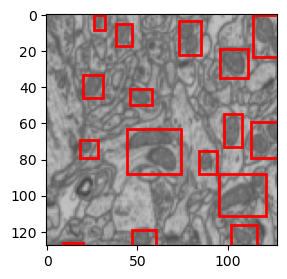

Bounding box 0: [  1.   1.  39. 122.  59. 128.]
Bounding box 1: [  1.   1. 108. 109. 128. 128.]
Bounding box 2: [  1.   1.  26. 109.  39. 123.]
Bounding box 3: [  1.   1. 109.  86. 122.  99.]
Bounding box 4: [  1.   1. 117.  67. 127.  78.]
Bounding box 5: [ 1.  1. 62. 65. 81. 96.]
Bounding box 6: [ 1.  1. 83. 59. 91. 74.]
Bounding box 7: [  1.   1. 108.  45. 115.  58.]
Bounding box 8: [  1.   1.  94.  45. 106.  64.]
Bounding box 9: [ 1.  1. 56. 45. 67. 55.]
Bounding box 10: [ 1.  1. 49. 31. 60. 40.]
Bounding box 11: [ 1.  1. 27. 28. 33. 35.]
Bounding box 12: [  1.   1.  96.  17. 118.  37.]
Bounding box 13: [ 1.  1. 40.  7. 49. 19.]
Bounding box 14: [  1.   1. 116.   5. 123.  13.]


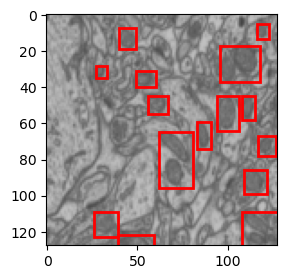

Bounding box 0: [  1.   1.  36. 122.  59. 128.]
Bounding box 1: [  1.   1.  27. 110.  39. 122.]
Bounding box 2: [  1.   1. 106. 108. 128. 128.]
Bounding box 3: [  1.   1. 105.  87. 121. 101.]
Bounding box 4: [  1.   1. 116.  67. 127.  79.]
Bounding box 5: [ 1.  1. 60. 63. 79. 96.]
Bounding box 6: [ 1.  1. 84. 62. 92. 77.]
Bounding box 7: [  1.   1. 124.  56. 128.  66.]
Bounding box 8: [  1.   1. 108.  46. 115.  57.]
Bounding box 9: [  1.   1.  95.  46. 106.  65.]
Bounding box 10: [ 1.  1. 54. 44. 67. 54.]
Bounding box 11: [ 1.  1. 48. 33. 58. 40.]
Bounding box 12: [ 1.  1. 25. 27. 34. 39.]
Bounding box 13: [  1.   1.  96.  17. 117.  38.]
Bounding box 14: [ 1.  1. 40.  7. 49. 19.]
Bounding box 15: [  1.   1. 115.   5. 124.  14.]
Bounding box 16: [ 1.  1. 78.  3. 88. 14.]


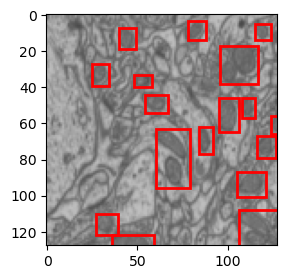

Bounding box 0: [  1.   1.   9. 126.  18. 128.]
Bounding box 1: [  1.   1.  49. 120.  60. 128.]
Bounding box 2: [  1.   1. 102. 115. 116. 128.]
Bounding box 3: [  1.   1.  96.  94. 115. 110.]
Bounding box 4: [ 1.  1. 84. 73. 94. 87.]
Bounding box 5: [ 1.  1. 46. 62. 75. 89.]
Bounding box 6: [  1.   1. 114.  58. 128.  79.]
Bounding box 7: [  1.   1.  97.  54. 108.  73.]
Bounding box 8: [ 1.  1. 47. 42. 59. 51.]
Bounding box 9: [ 1.  1. 21. 33. 32. 45.]
Bounding box 10: [  1.   1.  98.  19. 112.  34.]
Bounding box 11: [ 1.  1. 73.  5. 85. 21.]
Bounding box 12: [ 1.  1. 38.  5. 47. 17.]
Bounding box 13: [  1.   1. 115.   1. 128.  23.]
Bounding box 14: [ 1.  1. 26.  0. 32.  8.]


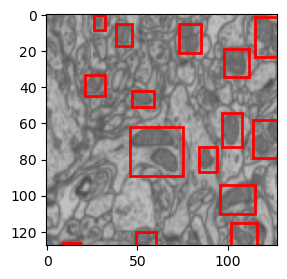

Bounding box 0: [  1.   1.  79. 125.  85. 128.]
Bounding box 1: [  1.   1.  24. 107.  36. 120.]
Bounding box 2: [  1.   1. 113.  85. 120.  94.]
Bounding box 3: [ 1.  1. 68. 68. 81. 86.]
Bounding box 4: [ 1.  1. 79. 51. 88. 64.]
Bounding box 5: [  1.   1. 106.  45. 114.  61.]
Bounding box 6: [  1.   1. 125.  42. 128.  50.]
Bounding box 7: [  1.   1.  93.  41. 104.  59.]
Bounding box 8: [ 1.  1. 28. 28. 36. 38.]
Bounding box 9: [ 1.  1. 46. 22. 60. 37.]
Bounding box 10: [  1.   1.  94.  15. 103.  31.]
Bounding box 11: [ 1.  1. 41.  9. 50. 18.]
Bounding box 12: [  1.   1. 116.   5. 122.  12.]


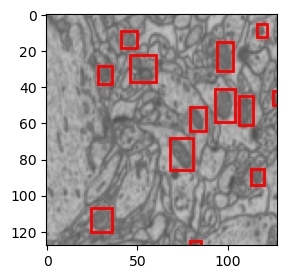

In [471]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

def plot_images_with_boxes(data_gen, num_images=5):
    """
    Plots a sample of images with bounding boxes from the data generator.
    :param data_gen: Data generator producing images and corresponding bounding boxes.
    :param num_images: Number of images to plot.
    """
    # Convert the generator to an iterator
    iterator = iter(data_gen)

    for _ in range(num_images):
        # Get next batch from the iterator
        images, annotations = next(iterator)
        image = images[0].numpy()  # Convert EagerTensor to NumPy and take the first image in the batch
        bboxes = annotations[0].numpy()  # Convert EagerTensor to NumPy for the bounding boxes of the first image

        # Plot the image
        plt.figure(figsize=(3, 3))
        plt.imshow(tf.squeeze(image), cmap='gray')  # Use tf.squeeze() here
        
        # Overlay bounding boxes
        ax = plt.gca()
        for i, bbox in enumerate(bboxes):
            # Only draw the rectangle if class confidence is greater than 0
            if bbox[0] > 0:
                print(f"Bounding box {i}: {bbox}")
                # Each bbox contains [class, confidence, x_min, y_min, x_max, y_max]
                width = bbox[4] - bbox[2]
                height = bbox[5] - bbox[3]
                rect = patches.Rectangle(
                    (bbox[2], bbox[3]), width, height,
                    linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        plt.show()

# Use your training data generator
plot_images_with_boxes(train_data_gen)


In [472]:
# Train the model
history = full_ssd_model.fit(
    train_images, new_train_labels,
    validation_data=(test_images, new_test_labels),
    epochs=60,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/60
11/11 [==============================] - ETA: 0s - loss: 3748.3076 - mean_io_u_2: 0.0000e+00
Epoch 1: val_loss did not improve from 72.29903
11/11 [==============================] - 5s 444ms/step - loss: 3748.3076 - mean_io_u_2: 0.0000e+00 - val_loss: 72.2990 - val_mean_io_u_2: 0.0000e+00 - lr: 1.0000e-14
Epoch 2/60
11/11 [==============================] - ETA: 0s - loss: 3749.7395 - mean_io_u_2: 0.0000e+00
Epoch 2: val_loss improved from 72.29903 to 72.29874, saving model to model_checkpoint.h5
11/11 [==============================] - 5s 498ms/step - loss: 3749.7395 - mean_io_u_2: 0.0000e+00 - val_loss: 72.2987 - val_mean_io_u_2: 0.0000e+00 - lr: 1.0000e-14
Epoch 3/60
11/11 [==============================] - ETA: 0s - loss: 3745.3645 - mean_io_u_2: 0.0000e+00
Epoch 3: val_loss did not improve from 72.29874
11/11 [==============================] - 5s 465ms/step - loss: 3745.3645 - mean_io_u_2: 0.0000e+00 - val_loss: 72.3021 - val_mean_io_u_2: 0.0000e+00 - lr: 1.0000e-14
Epoc

In [390]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Creating subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting training and validation loss
ax1.plot(train_loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting training and validation accuracy
ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(val_accuracy, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


KeyError: 'accuracy'

In [391]:
# Evaluate the model
# Replace 'test_data_gen' with your actual data generator or dataset
test_loss, test_accuracy = full_ssd_model.evaluate(val_data_gen)

11/11 [==============================] - 1s 68ms/step - loss: 72.2990 - mean_io_u_2: 0.0000e+00


In [392]:
# Assuming you have a dataset or a data generator for your validation/test set
# Let's say 'val_data_gen' is your data generator for validation data
val_images, val_labels = next(iter(val_data_gen))  # Get one batch of data

# Make predictions
preds = full_ssd_model.predict(val_images)

# Print the shape of the predictions
print("Predictions shape:", preds.shape)

# Print the last dimensions of the first few predictions
# Let's look at the first three predictions
for i in range(3):
    print(f"Sample {i} predictions:", preds[i, :, :])


1/1 [==============================] - 0s 84ms/step
Predictions shape: (16, 20, 6)
Sample 0 predictions: [[ 2.94962578e+01  2.92107754e+01  3.45885605e-01  1.21068522e-01
   3.30417633e-01 -1.82595570e-02]
 [ 2.63806171e+01  2.62653885e+01  1.37781873e-01  2.46008545e-01
   1.29024033e-02  1.68252796e-01]
 [ 2.59030666e+01  2.60258312e+01  4.65198085e-02  3.87660027e-01
  -9.34462920e-02  4.25902039e-01]
 [ 2.39267216e+01  2.38753529e+01  2.54348665e-01  7.21596405e-02
  -2.48471215e-01  5.73633378e-03]
 [ 2.33955441e+01  2.35157280e+01  1.31846353e-01 -2.24322259e-01
  -1.14183262e-01  1.14045598e-01]
 [ 2.56718349e+01  2.56873951e+01  4.62783486e-01 -2.46780187e-01
   6.19572215e-03  2.54877836e-01]
 [ 2.23698769e+01  2.22074261e+01 -1.61852702e-01  2.93664694e-01
   2.03934774e-01  4.34609145e-01]
 [ 2.07958755e+01  2.07673664e+01  2.33483538e-01  7.19633400e-02
  -1.79908156e-01  8.88374224e-02]
 [ 1.95764389e+01  1.96228886e+01  4.80066761e-02  4.44077700e-01
   2.21207932e-01  7.

In [394]:
pip install torch torchvision torchaudio


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/d6/a8/43e5033f9b2f727c158456e0720f870030ad3685c46f41ca3ca901b54922/torch-2.1.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/13/24/23cdf7e7dc33e5c01588c315f8424d31afa9edb05a80168f3d44f7178ff7/torchvision-0.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/3e/c4/bfaa620bba2e53e7707295bcc07b65871a52efe84510340ad79ce6a69be0/torchaudio-2.1.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 2.2/192.3 MB 48.5 MB/s eta 0:00:04
   - -------------------------------------- 5.5/192.3 MB 59.5 MB/s eta 0:00:04
   - -------------------------------------- 8.4/192.3 MB 59.6 MB/s eta 0:00:04
   - -------------------------------------- 8.6/192.3 MB 

In [617]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomSSD(nn.Module):
    def __init__(self, num_classes=2, num_boxes=18):
        super(CustomSSD, self).__init__()
        self.num_boxes = num_boxes  # Store num_boxes as an instance attribute
        self.num_classes = num_classes 
        # Load a pre-trained MobileNetV2 model
        base_model = models.mobilenet_v2(pretrained=True).features

        # Use selected layers from MobileNetV2 for feature extraction
        self.feature_extractor = base_model[:14]

        # Additional layers
        self.additional_layers = nn.ModuleList([
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Add more layers if needed
        ])

        # Prediction layers for classification and bounding boxes
        self.classifier = nn.Conv2d(in_channels=512, out_channels=num_boxes * num_classes, kernel_size=3, padding=1)
        self.regressor = nn.Conv2d(in_channels=512, out_channels=num_boxes * 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.feature_extractor(x)

        for layer in self.additional_layers:
            x = layer(x)

        # Get the height and width of the feature map
        feature_map_height, feature_map_width = x.shape[-2], x.shape[-1]

        # Process classifier outputs
        class_preds = self.classifier(x)
        class_preds = class_preds.permute(0, 2, 3, 1).contiguous()
        class_preds = class_preds.view(x.shape[0], -1, self.num_classes)

        # Apply softmax to classifier outputs to get probabilities
        class_preds = torch.softmax(class_preds, dim=-1)

        # Process regressor outputs
        bbox_regressions = self.regressor(x)
        bbox_regressions = bbox_regressions.permute(0, 2, 3, 1).contiguous()
        bbox_regressions = bbox_regressions.view(x.shape[0], -1, 4)

        # Separate class predictions, confidence scores, and bounding box regressions
        # Assuming the second value in the last dimension is the confidence score
        conf_scores = bbox_regressions[:, :, 1].unsqueeze(-1)
        # Apply sigmoid to confidence scores
        conf_scores = torch.sigmoid(conf_scores)

        # Concatenate class predictions, confidence scores, and bounding box regressions
        # Note: Here we are keeping the class label (first value) intact
        output = torch.cat([class_preds[:, :, 0].unsqueeze(-1), conf_scores, bbox_regressions], dim=-1)

        # Ensure that the output shape is [batch_size, num_boxes, num_classes + 1 (for confidence) + 4 (for bbox)]
        output = output[:, :self.num_boxes, :]

        return output


# Instantiate the model
ssd_model = CustomSSD(num_classes=2, num_boxes=18)

# Example usage
input_tensor = torch.randn(4, 3, 128, 128)  # Example input tensor
output = ssd_model(input_tensor)
print("Output shape:", output.shape)



Output shape: torch.Size([4, 18, 6])


In [659]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import tifffile as tiff
import os
import cv2

class CustomDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotations = []
        self.transform = transform or transforms.ToTensor()
        self.fixed_num_boxes = 18  # Fixed number of boxes

        # Load annotations from files ending with gt_{i}.json
        annotation_files = glob.glob(os.path.join(annotation_folder, '*gt_*.json'))
        for annotation_file in annotation_files:
            with open(annotation_file) as f:
                annotations_data = json.load(f)
                img_name = os.path.basename(annotation_file).replace('gt_', '').replace('.json', '.tif')
                img_path = os.path.join(image_folder, img_name)
                if os.path.exists(img_path):  # Check if the corresponding image file exists
                    self.annotations.append({'image': img_name, 'bbox': annotations_data})

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_folder, annotation['image'])
        image = tiff.imread(img_path)  # Use tifffile to read the image

        # Check if the image is loaded properly
        if image is None:
            print(f"Error loading image: {img_path}")
            return None

        if len(image.shape) == 2:  # Handle single-channel images
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Convert image to PyTorch tensor if not already done
        if not isinstance(image, torch.Tensor):
            image = self.transform(image)

        bbox = annotation['bbox']
        class_and_confidence = [[1, 1] for _ in bbox]  # Class = 1 and Confidence = 1 for actual objects

        # Ensure both bbox and class_and_confidence have the same length
        if len(bbox) > self.fixed_num_boxes:
            bbox = bbox[:self.fixed_num_boxes]
            class_and_confidence = class_and_confidence[:self.fixed_num_boxes]
        else:
            padding_length = self.fixed_num_boxes - len(bbox)
            bbox.extend([[0, 0, 0, 0]] * padding_length)
            class_and_confidence.extend([[0, 0]] * padding_length)

        # Convert to tensors and concatenate
        padded_bbox_tensor = torch.tensor(bbox, dtype=torch.float32)
        padded_class_conf_tensor = torch.tensor(class_and_confidence, dtype=torch.float32)
        padded_annotation = torch.cat((padded_class_conf_tensor, padded_bbox_tensor), dim=1)

        # Sanity check for number of boxes
        assert padded_annotation.shape[0] == self.fixed_num_boxes, "Mismatch in number of boxes"

        sample = {'image': image, 'bbox': padded_annotation}
        return sample

    def __len__(self):
        return len(self.annotations)
    
    
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transformations as needed
])


from torch.utils.data.dataloader import default_collate

# Load dataset
train_dataset = CustomDataset(image_folder=os.path.join(directory, 'reTrain'), 
                              annotation_folder=os.path.join(directory, 'reTrainJS'), 
                              transform=transform)
test_dataset = CustomDataset(image_folder=os.path.join(directory, 'reTest'), 
                              annotation_folder=os.path.join(directory, 'reTestJS'), 
                              transform=transform)

def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch if item is not None], dim=0)
    bbox_list = torch.stack([item['bbox'] for item in batch if item is not None], dim=0)
    return {'image': images, 'bbox': bbox_list}



# Then, when you create your DataLoader, specify the custom collate function:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


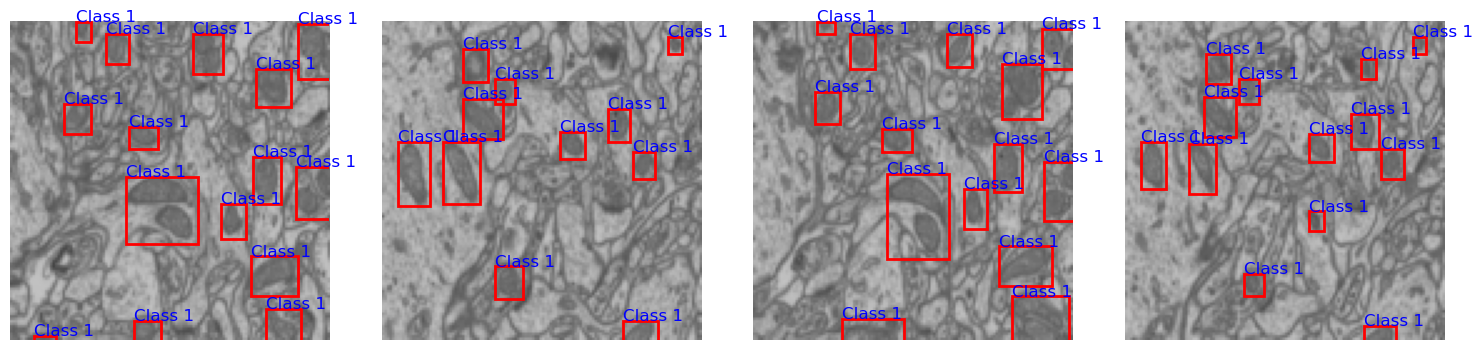

In [660]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(ax, bboxes):
    for bbox in bboxes:
        class_id, confidence, x_min, y_min, x_max, y_max = bbox
        # Only plot boxes with non-zero dimensions and actual objects (class_id == 1)
        if class_id == 1 and confidence > 0 and (x_min != x_max and y_min != y_max):
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'Class {int(class_id)}', color='blue', fontsize=12)

def plot_sample_images(data_loader, num_samples=4):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    data_iter = iter(data_loader)
    
    for i in range(num_samples):
        sample = next(data_iter)
        image = sample['image'][i].numpy().transpose((1, 2, 0))  # Convert to HWC format
        bboxes = sample['bbox'][i]

        # Filter out padding boxes (with all zero values)
        valid_bboxes = [bbox for bbox in bboxes if bbox.sum() > 0]

        axs[i].imshow(image, cmap='gray')
        draw_bounding_boxes(axs[i], valid_bboxes)
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


# Plot random samples from the train_loader
plot_sample_images(train_loader)


In [661]:
class SSDLoss(nn.Module):
    def __init__(self, alpha=1.0, num_classes=2):
        super(SSDLoss, self).__init__()
        self.alpha = alpha
        self.class_loss = nn.CrossEntropyLoss()
        self.box_loss = nn.SmoothL1Loss()
        self.num_classes = num_classes

    def forward(self, predictions, targets):
        # Split predictions and targets into classification and box predictions
        pred_classes = predictions[:, :, :self.num_classes]
        pred_boxes = predictions[:, :, self.num_classes:]

        target_classes = targets[:, :, :self.num_classes]
        target_boxes = targets[:, :, self.num_classes:]

        # Mask for non-padding boxes
        non_padding_mask = target_boxes.sum(dim=-1) != 0
        non_padding_mask_box = non_padding_mask.unsqueeze(-1).expand(-1, -1, 4)

        # Apply the mask to classification targets and predictions
        target_classes_masked = target_classes[non_padding_mask]
        pred_classes_masked = pred_classes[non_padding_mask]

        # Apply the mask to box targets and predictions
        target_boxes_masked = target_boxes[non_padding_mask_box]
        pred_boxes_masked = pred_boxes[non_padding_mask_box]

        # Reshape for loss calculation
        target_classes_masked = target_classes_masked.view(-1, self.num_classes)
        pred_classes_masked = pred_classes_masked.view(-1, self.num_classes)

        target_boxes_masked = target_boxes_masked.view(-1, 4)
        pred_boxes_masked = pred_boxes_masked.view(-1, 4)

        # Calculate classification and box losses
        classification_loss = self.class_loss(pred_classes_masked, target_classes_masked.argmax(dim=-1))
        box_loss = self.box_loss(pred_boxes_masked, target_boxes_masked)

        # Combine losses
        total_loss = classification_loss + self.alpha * box_loss
        return total_loss


In [662]:
from sklearn.metrics import precision_score, recall_score

def calculate_iou(pred_box, true_box):
    # Calculate intersection areas
    x_min = max(pred_box[0], true_box[0])
    y_min = max(pred_box[1], true_box[1])
    x_max = min(pred_box[2], true_box[2])
    y_max = min(pred_box[3], true_box[3])

    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    true_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
    union_area = pred_area + true_area - intersection_area

    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

In [663]:
import torch.optim as optim
import torch
print(torch.version.cuda)

# Instantiate the model
ssd_model = CustomSSD()
ssd_loss_fn = SSDLoss(alpha=1.0)

# Hyperparameters
num_epochs = 200
learning_rate = 0.001

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Move the model and the loss function to the device (GPU or CPU)
ssd_model.to(device)
ssd_loss_fn.to(device)

# Define the optimizer
optimizer = optim.Adam(ssd_model.parameters(), lr=learning_rate)

None
Training on device: cpu


In [664]:
# Training loop
loss_history = []
iou_history = []

for epoch in range(num_epochs):
    ssd_model.train()
    running_loss = 0.0
    running_iou = 0.0
    num_batches = 0

    for batch in train_loader:
        images = batch['image'].to(device)
        targets = batch['bbox'].to(device)

        # Forward pass and loss calculation
        predictions = ssd_model(images)
        try:
            loss = ssd_loss_fn(predictions, targets)
        except IndexError as e:
            print("Error during loss calculation:", e)
            continue 

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # IoU calculation for each batch
        for i in range(len(targets)):
            pred_boxes = predictions[i, :, 2:].detach().cpu().numpy()
            true_boxes = targets[i, :, 2:].cpu().numpy()
            ious = [calculate_iou(pred, true) for pred, true in zip(pred_boxes, true_boxes)]
            running_iou += sum(ious) / len(ious)

        num_batches += 1

    # Average loss and IoU for the epoch
    epoch_loss = running_loss / num_batches
    epoch_iou = running_iou / num_batches

    # Store the epoch data
    loss_history.append(epoch_loss)
    iou_history.append(epoch_iou)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Average IoU: {epoch_iou}")

print("Training complete")

# At this point, loss_history and iou_history contain the loss and IoU data for each epoch


Epoch 1/200, Loss: 28.769948051089333, Average IoU: 0.036752480883185154
Epoch 2/200, Loss: 19.551410606929235, Average IoU: 0.0942438552409955
Epoch 3/200, Loss: 17.513522466023762, Average IoU: 0.11235702632553443
Epoch 4/200, Loss: 15.700468653724307, Average IoU: 0.19145664860873524
Epoch 5/200, Loss: 15.818613915216355, Average IoU: 0.14849851214119297
Epoch 6/200, Loss: 14.702028047470819, Average IoU: 0.18976029041326403
Epoch 7/200, Loss: 13.478171348571777, Average IoU: 0.23120456393025565
Epoch 8/200, Loss: 12.690066258112589, Average IoU: 0.28248935711536877
Epoch 9/200, Loss: 11.924189442679996, Average IoU: 0.3155738335346599
Epoch 10/200, Loss: 12.451306513377599, Average IoU: 0.29082425322992217
Epoch 11/200, Loss: 11.648727371579124, Average IoU: 0.3508609962350637
Epoch 12/200, Loss: 11.418107850211006, Average IoU: 0.3767464930610117
Epoch 13/200, Loss: 11.12392654873076, Average IoU: 0.35729123001577273
Epoch 14/200, Loss: 10.619734627859932, Average IoU: 0.381420608

Epoch 116/200, Loss: 3.294832073506855, Average IoU: 1.400010892096876
Epoch 117/200, Loss: 3.7033109948748635, Average IoU: 1.2785121333727152
Epoch 118/200, Loss: 4.432103514671326, Average IoU: 1.042566283285389
Epoch 119/200, Loss: 4.390147203490848, Average IoU: 1.1792822906630005
Epoch 120/200, Loss: 4.194824934005737, Average IoU: 1.2682023286047117
Epoch 121/200, Loss: 4.438341481345041, Average IoU: 1.1593200785932816
Epoch 122/200, Loss: 4.748343859400068, Average IoU: 1.0566090835040012
Epoch 123/200, Loss: 4.153969231105986, Average IoU: 1.124825448322568
Epoch 124/200, Loss: 3.561788570313227, Average IoU: 1.2717415484308614
Epoch 125/200, Loss: 3.487006502492087, Average IoU: 1.3234681602955565
Epoch 126/200, Loss: 3.9564013481140137, Average IoU: 1.147192496767039
Epoch 127/200, Loss: 4.0781462873731344, Average IoU: 1.0913471573150393
Epoch 128/200, Loss: 3.6294005598340715, Average IoU: 1.1883495252285106
Epoch 129/200, Loss: 3.173724285193852, Average IoU: 1.325855417

Decreasing Loss: The loss generally decreases over epochs, which is a good sign. It indicates that the model is learning from the training data, and its predictions are getting closer to the actual targets. However, there are slight increases in loss at some points, which could be due to the variability in the data or the learning process.

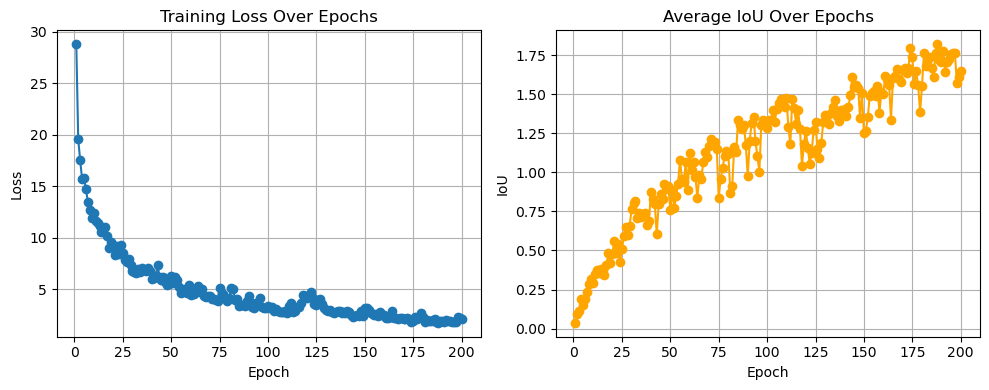

In [665]:
# Plotting Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plotting IoU
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), iou_history, marker='o', color='orange')
plt.title('Average IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.grid(True)

plt.tight_layout()
plt.show()


In [666]:
ssd_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Loop over the validation dataset
    for batch in val_loader:
        images = batch['image'].to(device)
        targets = batch['bbox'].to(device)
        predictions = ssd_model(images)
        # Compute evaluation metrics here

Pred Box 2: Class 1, Confidence 1.00, Box [80.73534393310547, 111.38072967529297, 90.19223022460938, 119.50845336914062]
Pred Box 2: Class 1, Confidence 1.00, Box [45.255882263183594, 90.9708251953125, 55.00439453125, 102.50297546386719]
Pred Box 2: Class 1, Confidence 1.00, Box [47.83794403076172, 59.576072692871094, 58.48063659667969, 75.57158660888672]
Pred Box 2: Class 1, Confidence 1.00, Box [60.9718017578125, 51.40531921386719, 70.93157958984375, 66.0735855102539]
Pred Box 2: Class 1, Confidence 1.00, Box [49.729827880859375, 49.633811950683594, 61.545936584472656, 69.25333404541016]
Pred Box 2: Class 1, Confidence 1.00, Box [65.95065307617188, 40.953460693359375, 75.22111511230469, 53.11087417602539]
Pred Box 2: Class 1, Confidence 1.00, Box [45.80913543701172, 36.80388641357422, 57.41143035888672, 47.753875732421875]
Pred Box 2: Class 1, Confidence 1.00, Box [80.65895080566406, 33.30952453613281, 88.96792602539062, 42.39854431152344]
Pred Box 2: Class 1, Confidence 1.00, Box [7

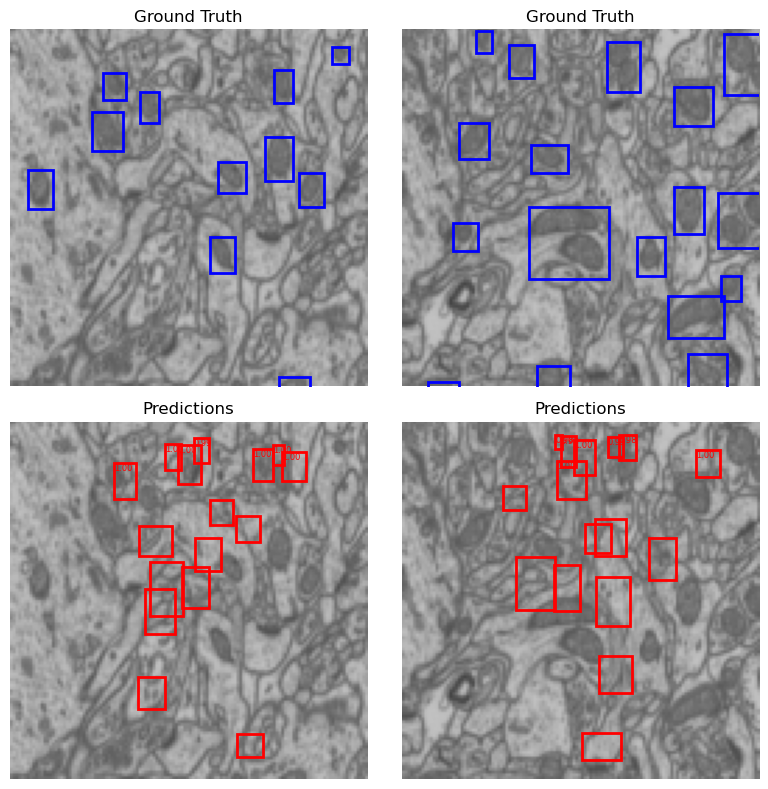

In [667]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(ax, bboxes, color, print_confidence=False):
    for bbox in bboxes:
        # Unpack bounding box coordinates and class/confidence
        class_id, confidence, x_min, y_min, x_max, y_max = bbox
        # Only plot boxes with non-zero dimensions and actual objects (class_id == 1)
        if class_id == 1 and (x_min != x_max and y_min != y_max):
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            if print_confidence:
                # Display confidence above the bounding box for predictions
                if confidence < 1.0:
                    ax.text(x_min, y_min, f'{confidence:.2f}', color=color, fontsize=6, verticalalignment='top')
                print(f'Pred Box {idx}: Class {int(class_id)}, Confidence {confidence:.2f}, Box [{x_min}, {y_min}, {x_max}, {y_max}]')

def plot_sample_images_with_true_annotations(data_loader, predictions, threshold, num_samples=2):
    fig, axs = plt.subplots(2, num_samples, figsize=(8, 8))  # Adjusted for 2 images
    data_iter = iter(data_loader)
    
    for i in range(num_samples):
        sample = next(data_iter)
        image = sample['image'][0].numpy().transpose((1, 2, 0))  # Convert to HWC format
        
        true_bboxes = sample['bbox'][0]
        pred_bboxes = predictions[i]

        # Filter out padding boxes (with all zero values) for true annotations
        valid_true_bboxes = [bbox for bbox in true_bboxes if bbox.sum() > threshold]

        # First row for ground truth
        axs[0, i].imshow(image, cmap='gray')
        draw_bounding_boxes(axs[0, i], valid_true_bboxes, 'blue')
        axs[0, i].set_title('Ground Truth')
        axs[0, i].axis('off')
        
        # Second row for predictions
        axs[1, i].imshow(image, cmap='gray')
        draw_bounding_boxes(axs[1, i], pred_bboxes, 'red', print_confidence=True)
        axs[1, i].set_title('Predictions')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


# To use the function, you will need to create a list of predictions for the images you want to plot.
# Here's an example of how to create such a list:

ssd_model.eval()
predictions = []
with torch.no_grad():
    for i in range(num_samples):  # Assuming num_samples is defined
        test_image = test_dataset[i]['image'].unsqueeze(0).to(device)  # Add batch dimension
        prediction = ssd_model(test_image)[0]  # Get the prediction for this image
        predictions.append(prediction.cpu())

# Now call the plotting function with the train_loader and the predictions
plot_sample_images_with_true_annotations(train_loader, predictions, threshold = 0, num_samples=2)


Pred Box 2: Class 1, Confidence 1.00, Box [6.1970930099487305, 123.7490463256836, 19.09636688232422, 126.53025817871094]
Pred Box 2: Class 1, Confidence 1.00, Box [49.55780029296875, 119.07316589355469, 60.55376434326172, 127.56404876708984]
Pred Box 2: Class 1, Confidence 1.00, Box [103.12306213378906, 116.6275634765625, 115.57553100585938, 127.17030334472656]
Pred Box 2: Class 1, Confidence 1.00, Box [95.07325744628906, 86.02881622314453, 121.79151153564453, 109.29193115234375]
Pred Box 2: Class 1, Confidence 1.00, Box [84.43346405029297, 74.39678955078125, 94.08071899414062, 88.08009338378906]
Pred Box 2: Class 1, Confidence 1.00, Box [16.960235595703125, 69.07394409179688, 27.553403854370117, 79.23603820800781]
Pred Box 2: Class 1, Confidence 1.00, Box [40.681983947753906, 62.788848876953125, 73.19387817382812, 87.67549133300781]
Pred Box 2: Class 1, Confidence 1.00, Box [113.28269958496094, 58.252750396728516, 127.98177337646484, 77.76583099365234]
Pred Box 2: Class 1, Confidence 

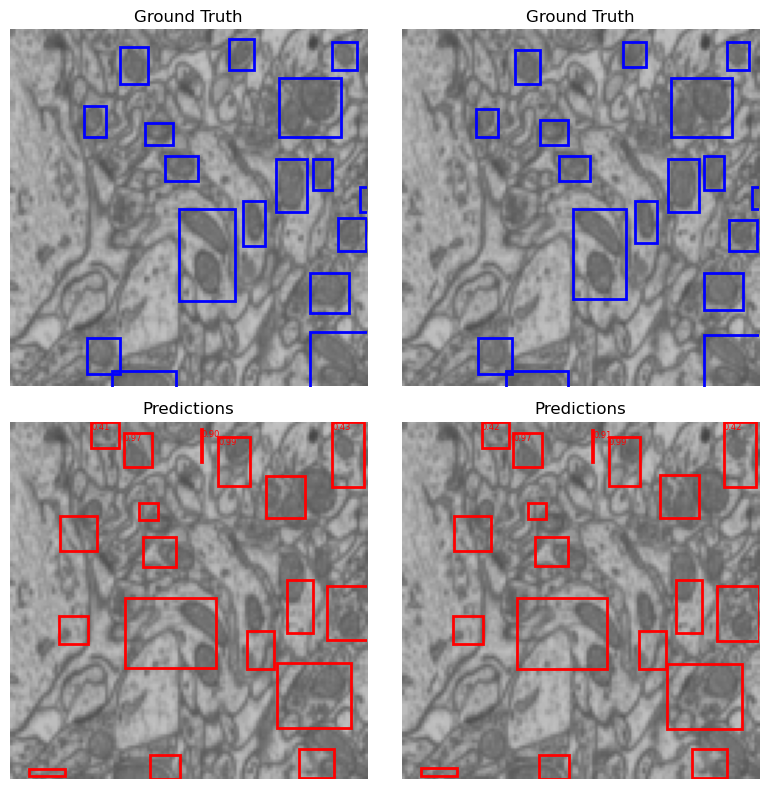

In [668]:

ssd_model.eval()
predictions = []
with torch.no_grad():
    for i in range(num_samples):  # Assuming num_samples is defined
        test_image = train_dataset[i]['image'].unsqueeze(0).to(device)  # Add batch dimension
        prediction = ssd_model(test_image)[0]  # Get the prediction for this image
        predictions.append(prediction.cpu())

# Now call the plotting function with the train_loader and the predictions
plot_sample_images_with_true_annotations(train_loader, predictions, threshold = 0, num_samples=2)